In [14]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.mortality.final_model_loss_train_mortality import *
from model.final_model.mortality.final_model_mortality import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.mortality.plot import *


import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()


In [ ]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)


train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=32,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=32,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [5]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage6_higher_kappa/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_30_eachtime"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=50, save_dir=save_path, 
            gamma=100, beta=150, kappa=200,  eta=1, 
            patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Early stopping at epoch 23 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


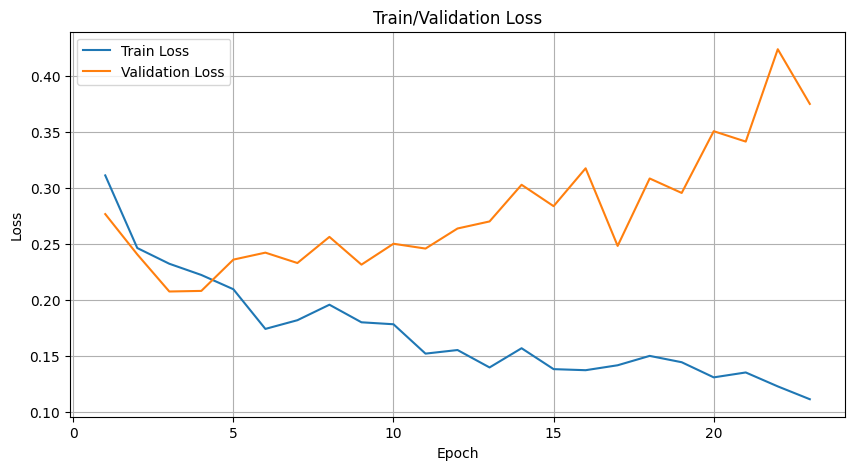

In [7]:
plot_training_history(history)

In [11]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_30_eachtime/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [11]:
output= test_patient_outcome_model(model, test_loader, device)

Best threshold: 0.1819989 → F1: 0.6181818132082645
Total test samples: 461
Number of actual deaths: 51
Predictions range: min= 0.0027678167  max= 0.7778162
Mean predicted death probability: 0.09206442
Test Mortality - AUROC: 0.9206, AUPRC: 0.6658, Precision: 0.5763, Recall: 0.6667,pecificity: 0.9390, F1: 0.6182


In [ ]:
print_statistics_of_dataloaer (test_loader)

test_loader 中 cat=0 的样本索引： [327, 194, 122, 161, 303, 123, 127, 51, 117, 109, 241, 279, 48, 61, 53, 302, 18, 114, 131, 77, 75, 88, 46, 43, 418, 71, 330]
cat=0 的患者 ID: [3118263, 2441148, 1848702, 2235716, 3064491, 1849239, 1854497, 1721495, 1842081, 1822777, 2642496, 2851573, 1718669, 1730209, 1722941, 3063135, 1334230, 1833798, 1857925, 1764355, 1762378, 1788553, 1364166, 1358338, 3232813, 1754475, 3123772]
cat=0 的样本长度: [475, 246, 152, 145, 80, 79, 58, 57, 55, 49, 49, 49, 48, 48, 47, 47, 44, 44, 44, 43, 42, 41, 39, 36, 36, 35, 32]
test_loader 中 cat=1 的样本索引： [15, 235, 28, 286, 267, 326, 98, 188, 334, 380, 52, 331, 240, 273, 352, 423, 56, 70, 42, 391, 179, 377, 217, 103, 140, 269, 356, 40, 76, 236, 408, 97, 130, 416, 315, 99, 208, 0, 372, 407, 319, 102, 126, 378, 347, 409, 219, 313, 368, 92, 72, 417, 111, 403, 447, 289, 31, 178, 81, 390, 229, 67, 115, 184, 3, 263, 419, 277, 439, 294, 274, 437, 268, 54, 264, 354, 259, 388, 191, 124, 311, 340, 233, 255, 105, 299, 246, 73, 5, 26, 35, 116, 1,

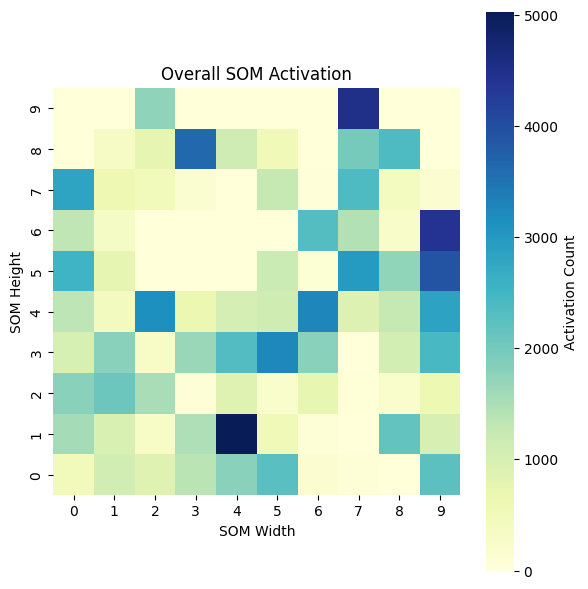

In [15]:

som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

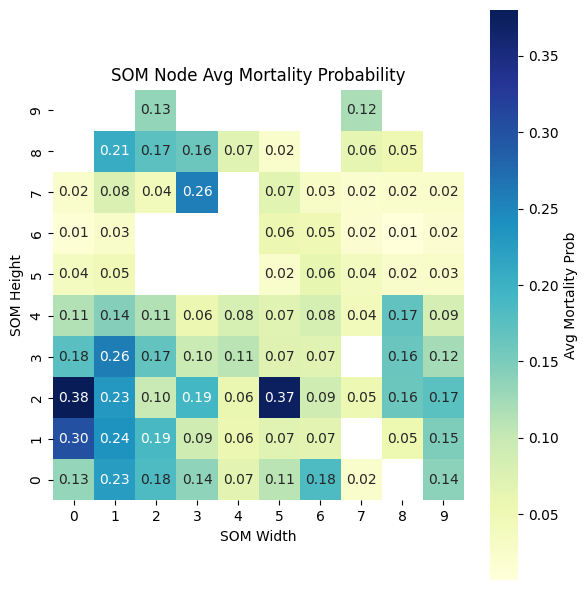

In [16]:
som_dim = (10,10)
mort_heatmap = compute_som_avg_mortality_prob(model, test_loader, device, som_dim)
plot_som_avg_mortality_prob(mort_heatmap, som_dim)

In [193]:
som_dim = (10,10)
mort_heatmap = compute_som_avg_mortality_prob(model, test_loader, device
                                              , som_dim)

--- Searching for specified patient IDs: ['3118263'] ---


Searching for patients:  67%|██████▋   | 10/15 [00:00<00:00, 21.17it/s]


  -> Found 1 target(s) in batch. Forward pass...
    -> Trajectory for ID=3118263, category=0, mortality=0
--- All targets found. ---

Plotting trajectory snapshots at timesteps: [474]


/tmp/ipykernel_2470564/1536795101.py:275: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.5, 0.96])


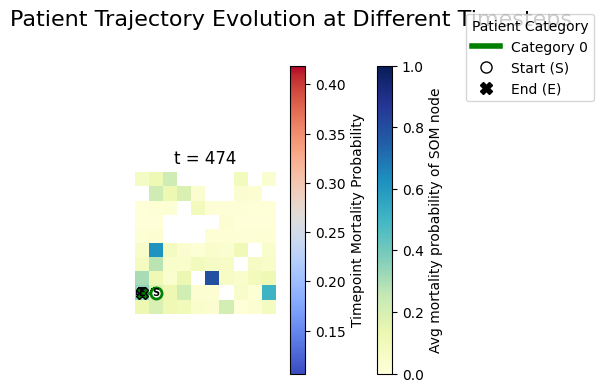

In [261]:
patient_ids = ['3118263'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=mort_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['2452034'] ---


Searching for patients:  40%|████      | 6/15 [00:00<00:00, 13.73it/s]


  -> Found 1 target(s) in batch. Forward pass...
    -> Trajectory for ID=2452034, category=3, mortality=1
--- All targets found. ---

Plotting trajectory snapshots at timesteps: [356]


/tmp/ipykernel_2470564/1536795101.py:275: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.5, 0.96])


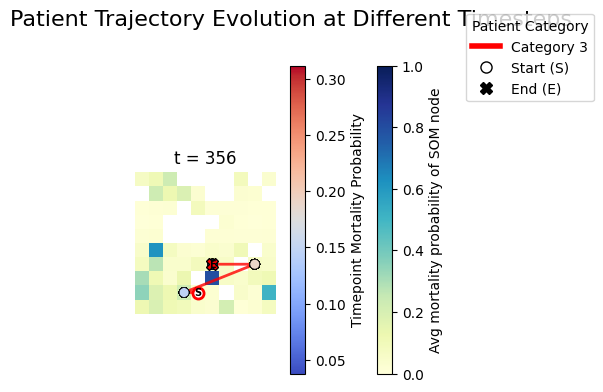

In [263]:
patient_ids = ['2452034'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=mort_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)